In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TkAgg') # 在Ubuntu上执行代码，如果想从窗口中弹出图形，需要加上这一行

# 生成数据，使用线性模型 y = w * x + b + noise，指定seed，保证每次运行代码生成的数据一致
# np.random.seed(42)
X_train = np.arange(100).reshape(100, 1)
a, b = 1, 10
y_train = a * X_train + b + np.random.normal(0, 5, size=X_train.shape)
y_train = y_train.reshape(-1)

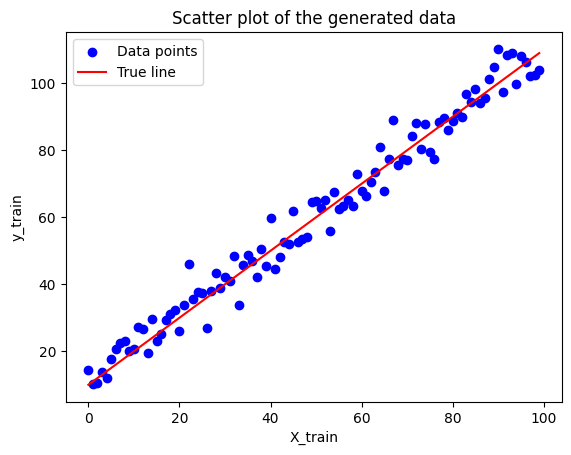

In [5]:
plt.scatter(X_train, y_train, color='blue', label='Data points')
plt.plot(X_train, a * X_train + b, color='red', label='True line')
plt.xlabel('X_train')
plt.ylabel('y_train')
plt.title('Scatter plot of the generated data')
plt.legend()
plt.show()

展示了数据与ground truth的直观表达。

In [7]:
class LinearRegression():

    def __init__(self, n_feature = 1, epochs = 100, lr = 1e-5):
        self.n_feature = n_feature
        self.epochs = epochs
        self.W = np.random.random(n_feature + 1) * 0.05
        self.loss = []
        self.epoch_loss = []
        self.lr = lr

    def _loss(self, y, y_pred):
        return np.sum((y - y_pred) ** 2) / y.size

    def gradient(self, X, y, y_pred):
        return (y_pred - y) @ X / y.size

    def _preprocess(self, X):
        m, n = X.shape
        X_ = np.empty([m, n + 1])
        X_[:, 0] = 1
        X_[:, 1:] = X
        return X_

    def _predict(self, X):
        return X @ self.W

    def predict(self, X):
        X_ = self._preprocess(X)
        return self._predict(X_)
    
    def BGD(self, X, y):
        X_ = self._preprocess(X)
        self.loss.append(self._loss(y, self._predict(X_)))
        self.epoch_loss.append(self._loss(y, self._predict(X_)))

        for _ in range(self.epochs):
            y_pred = self._predict(X_)
            self.W -= self.lr * self.gradient(X_, y, y_pred) # gradient descent
            self.loss.append(self._loss(y, y_pred))
            self.epoch_loss.append(self._loss(y, y_pred))
    
    def SGD(self, X, y):
        X_ = self._preprocess(X)
        self.loss.append(self._loss(y, self._predict(X_)))
        self.epoch_loss.append(self._loss(y, self._predict(X_)))

        for _ in range(self.epochs):
            shuffle_index = np.random.permutation(X_.shape[0])
            X_ = X_[shuffle_index]
            y = y[shuffle_index]
            for i in range(len(y)):
                xi = X_[i].reshape(1, -1)  # Select a single data point and reshape to match input dimension
                yi = y[i].reshape(-1)       # Select the corresponding target value and reshape to match output dimension
                y_pred = self._predict(xi)
                self.W -= self.lr * self.gradient(xi, yi, y_pred).flatten()  # Update weights based on single data point
                self.loss.append(self._loss(yi, y_pred))
            
            y_pred_epoch = self._predict(X_)
            self.epoch_loss.append(self._loss(y, y_pred_epoch))
            

    def MBGD(self, X, y, batch_size):
        X_ = self._preprocess(X)
        num_batches = len(y) // batch_size
        self.loss.append(self._loss(y, self._predict(X_)))
        self.epoch_loss.append(self._loss(y, self._predict(X_)))

        for _ in range(self.epochs):
            shuffle_index = np.random.permutation(X_.shape[0])
            X_ = X_[shuffle_index]
            y = y[shuffle_index]
            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size
                xi = X_[start:end]  # Select a batch of data points
                yi = y[start:end]   # Select the corresponding target values
                y_pred = self._predict(xi)
                self.W -= self.lr * self.gradient(xi, yi, y_pred)  # Update weights based on the batch
                self.loss.append(self._loss(yi, y_pred))

            # Compute loss for the entire dataset
            y_pred_epoch = self._predict(X_)
            self.epoch_loss.append(self._loss(y, y_pred_epoch))

    def minmax_norm(self, X):
        return (X - X.min()) / (X.max() - X.min())

    def mean_norm(self, X):
        return (X - X.mean()) / X.std()

    

对每一个session，都创建一个LinearRegression现象，来确保运行结果相对独立

上面的代码用来准备归一化后的数据。plt可以直观地展示归一化的效果。

In [9]:
gd_lreg = LinearRegression()
gd_lreg.BGD(X_train, y_train)

sgd_lreg = LinearRegression()
sgd_lreg.SGD(X_train, y_train)

mbgd_lreg = LinearRegression()
mbgd_lreg.MBGD(X_train, y_train, 10)


训练，默认的学习率为1e-5，100个epoch

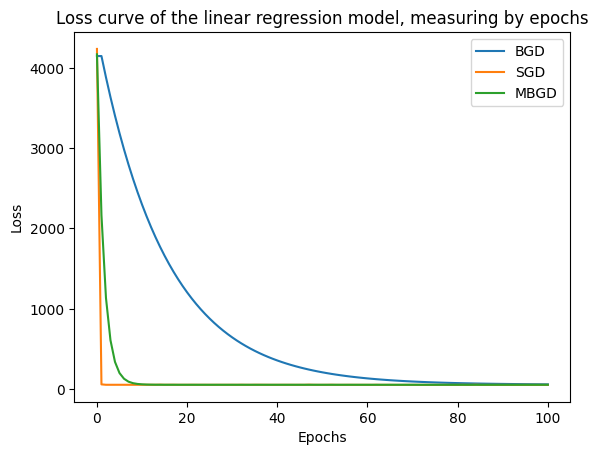

In [10]:
plt.plot(gd_lreg.epoch_loss)
plt.plot(sgd_lreg.epoch_loss)
plt.plot(mbgd_lreg.epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['BGD', 'SGD', 'MBGD'])
plt.title('Loss curve of the linear regression model, measuring by epochs')
plt.show()


在100epoch时，3种方法都基本收敛。其中，SGD收敛最快，MBGD（batch_size=10）次之，BGD最慢。下图将进一步解释。

p.s. 这里有一个值得注意的编程技巧。在计算loss的时候，应该在做第一次梯度下降之前取一次，不然三者的初值（都经过梯度下降后）大概率不一致。

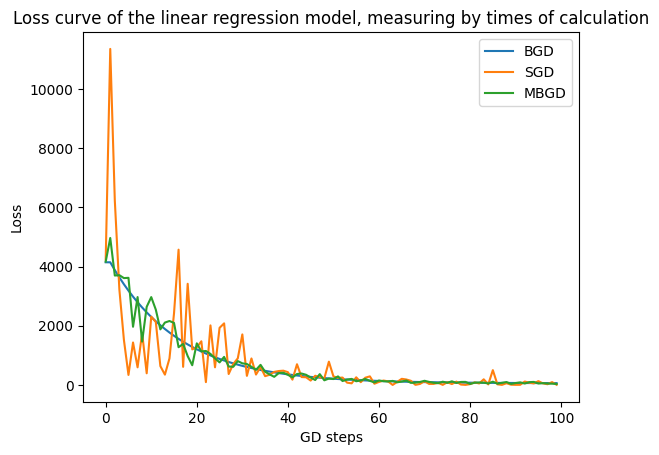

In [11]:

plt.plot(gd_lreg.loss[:100])
plt.plot(sgd_lreg.loss[:100])
plt.plot(mbgd_lreg.loss[:100])
plt.xlabel('GD steps')
plt.ylabel('Loss')
plt.legend(['BGD', 'SGD', 'MBGD'])
plt.title('Loss curve of the linear regression model, measuring by times of calculation')
plt.show()

这里是以计算次数作为x轴的loss图标。
可以发现，三者在80次计算后基本收敛，但是SGD仍然具有明显毛刺现象。
在计算的初期，SGD非常不稳定，loss值经常发现较大的跳变，但是在一定量的计算数过后，同样可以收敛。
BGD随计算次数的收敛是最平稳的。MBGD，作为二者的中间值，其收敛特性也是二者的混合。

因为对于SGD来说，一个epoch有80次计算，所以上一张图中，SGD是收敛最快的。同时，由于是每隔80次取一个loss，毛刺也被磨平了。
但是，这也意味着对于SGD，这个超参数组合有较大的过拟合风险。

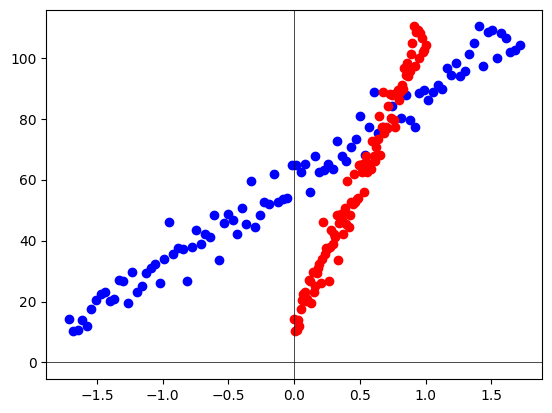

In [ ]:
norm_test = LinearRegression()
X_minmax = norm_test.minmax_norm(X_train)
X_mean = norm_test.mean_norm(X_train)

plt.scatter(X_mean, y_train, color='blue', label='Data points')
plt.scatter(X_minmax, y_train, color='red', label='Data points')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.show()

In [19]:

mbgd_lreg = LinearRegression()
mbgd_lreg.MBGD(X_train, y_train, 10)

minmax_mbgd_lreg = LinearRegression()
minmax_mbgd_lreg.lr = 0.1
minmax_mbgd_lreg.MBGD(X_minmax, y_train, 10)

mean_mbgd_lreg = LinearRegression()
mean_mbgd_lreg.lr = 0.1
mean_mbgd_lreg.MBGD(X_mean, y_train, 10)


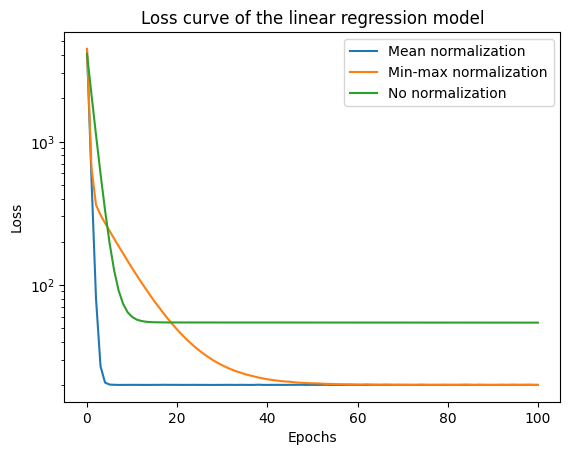

In [32]:

plt.plot(mean_mbgd_lreg.epoch_loss)
plt.plot(minmax_mbgd_lreg.epoch_loss)
plt.plot(mbgd_lreg.epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(['Mean normalization', 'Min-max normalization', 'No normalization'])
plt.title('Loss curve of the linear regression model')
plt.show()

采用log坐标轴，能更清楚地看出曲线之间的差异。
采用两种归一化方法均有助于loss的收敛。
需要注意的是，使用归一化后，需要调整超参数，尤其是学习率。这里其他超参数均不变，归一化后的网络取学习率为0.1（对于原来的网络来说是非常大的学习率了）

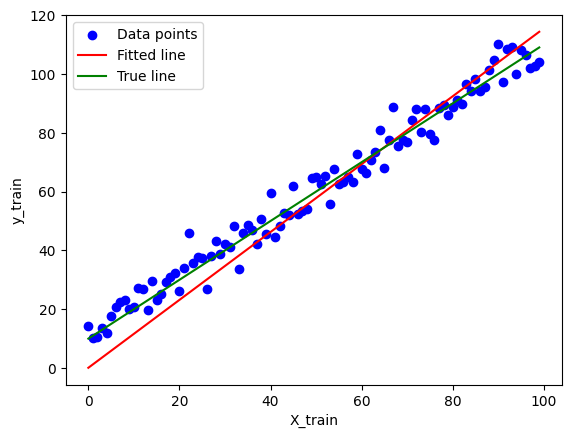

In [36]:
plt.scatter(X_train, y_train, color='blue', label='Data points')
plt.plot(X_train, mbgd_lreg.predict(X_train), color='red', label='Fitted line')
plt.plot(X_train, a * X_train + b, color='green', label='True line')
plt.xlabel('X_train')
plt.ylabel('y_train')
plt.legend()
plt.show()


可以看到100 epoch后的数据拟合情况。